In [8]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [9]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [23]:
lfw_people['data'].shape

(1288, 1850)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

In [14]:
scaler = StandardScaler()
lr_model = LogisticRegression()
rf_model = RandomForestClassifier(max_depth = 8)
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
pca = PCA(150, svd_solver = 'randomized', whiten = True)
lr_pipe = make_pipeline(scaler, pca, lr_model)
rf_pipe = make_pipeline(scaler, pca, rf_model)
svc_pipe = make_pipeline(scaler, pca, clf)

In [16]:
svc_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=150, svd_solver='randomized', whiten=True)),
                ('randomizedsearchcv',
                 RandomizedSearchCV(estimator=SVC(class_weight='balanced'),
                                    param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001F4225D3190>,
                                                         'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001F421205A90>}))])

In [17]:
y_preds = svc_pipe.predict(X_test)

In [20]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62        13
           1       0.77      0.90      0.83        60
           2       0.86      0.67      0.75        27
           3       0.88      0.96      0.92       146
           4       1.00      0.80      0.89        25
           5       1.00      0.53      0.70        15
           6       0.94      0.81      0.87        36

    accuracy                           0.86       322
   macro avg       0.87      0.75      0.79       322
weighted avg       0.87      0.86      0.86       322



In [4]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 2.855s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s


In [7]:
X_train_pca

array([[-1.1066924 , -1.0626007 ,  0.79254174, ..., -0.19176365,
         0.29107833,  0.95494026],
       [ 1.0323536 ,  0.3646463 , -0.7926172 , ...,  0.322693  ,
        -0.32718334,  0.59439605],
       [ 0.07175076, -0.30826953,  0.2541037 , ...,  0.00309171,
        -0.5203131 , -0.4264305 ],
       ...,
       [ 0.18818992,  0.14722337, -0.52081716, ...,  0.29817972,
         0.36793345,  0.06602441],
       [-0.5832538 ,  0.92357856, -1.0066847 , ...,  0.7368155 ,
         0.21482915, -0.4977382 ],
       [-1.5008026 , -0.81850296, -0.85659444, ..., -1.1986477 ,
        -0.08133408,  0.8815158 ]], dtype=float32)

In [5]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 3.478s
Best estimator found by grid search:
SVC(C=7057.9272485168, class_weight='balanced', gamma=0.0024483770378045115)


Predicting people's names on the test set
done in 0.028s
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.77      0.71        13
     Colin Powell       0.73      0.87      0.79        60
  Donald Rumsfeld       0.75      0.67      0.71        27
    George W Bush       0.93      0.91      0.92       146
Gerhard Schroeder       0.80      0.80      0.80        25
      Hugo Chavez       0.83      0.67      0.74        15
       Tony Blair       0.91      0.81      0.85        36

         accuracy                           0.84       322
        macro avg       0.80      0.78      0.79       322
     weighted avg       0.85      0.84      0.85       322



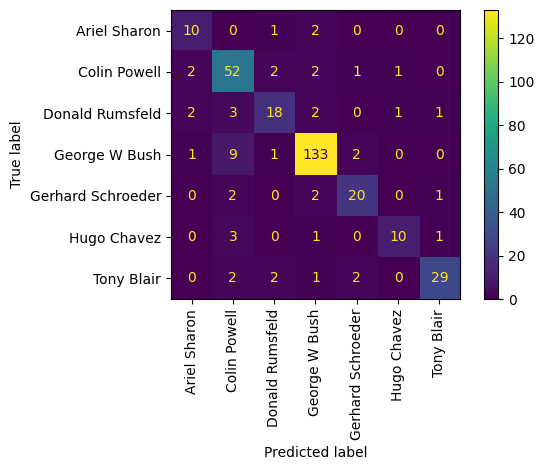

In [6]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()